<h2><font color="#000000" size=6>Minería de datos</font></h2>
<h1><font color="#000000" size=5>PEC 4 - Random Forest</font></h1>
<br><br>
<div style="text-align: right">
<font color="#000000" size=3>Estudiante: Fernando H. Nasser-Eddine López</font><br>
<font color="#000000" size=3>Máster Universitario en Investigación en Inteligencia Artificial (MUIIA)</font><br>
<font color="#000000" size=3>Mayo 2025</font><br>
</div>

<h2><font color="#000000" size=5>Índice</font></h2><a id="indice"></a>

* [2. Fase de preprocesamiento y tratamiento de datos](#section2)
   * [2.1. Técnicas de preprocesamiento básicas](#section21)
       * [2.1.1. Normalización y estandarización](#section211)
       * [2.1.2. Resultados de la normalización para los valores atípicos](#section212)

# <a id="section2">2. Fase de preprocesamiento y tratamiento de datos</a>

En esta segunda fase del proyecto, realizamos el preprocesamiento y tratamiento de los datos para prepararlos adecuadamente para la fase de modelado. El preprocesamiento es fundamental para mejorar el rendimiento de los algoritmos de aprendizaje automático, especialmente cuando trabajamos con variables numéricas que presentan diferentes escalas y distribuciones.

## Importación de librerías y carga de datos</font><a id="section11"></a>


En esta sección realizamos la importación de todas las librerías que utilizaremos a lo largo del análisis. Principalmente, usamos pandas para la manipulación de datos, matplotlib y seaborn para visualizaciones, así como scikit-learn para los algoritmos de aprendizaje automático y evaluación de modelos.

Cargamos el conjunto de datos Breast Cancer Wisconsin (Diagnostic) directamente desde scikit-learn, que proporciona una versión curada de este dataset.

In [1]:
# Importación de las librerías necesarias
import time
import warnings
import os
import pickle

import nbimporter
from a_analisis import detect_outliers_comprehensive

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, roc_auc_score, classification_report, 
                            roc_curve, auc)

# Modelos base
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Modelos ensemble
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier)

# Explicabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Evitar warnings innecesarios
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [2]:
# Carga del dataset de cáncer de mama de Wisconsin
cancer = load_breast_cancer()

# Crear un DataFrame para una mejor manipulación de los datos
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target, name='target')

# Asignar nombres a las clases para mejor interpretación
y_labels = y.map({0: 'maligno', 1: 'benigno'})

# Crear un DataFrame completo con las características y las variables objetivo
X_completo = X.copy()
X_completo['target'] = y  # Variable numérica original
X_completo['diagnosis'] = y_labels  # Variable mapeada

## <a id="section21">2.1 Técnicas de preproceseado</a>

### <font color="#000000"> 2.1.1. Normalización y estandarización</font><a id="section211"></a>

Basándonos en las características identificadas en nuestro análisis exploratorio, aplicamos distintas técnicas de preprocesamiento adaptadas a cada tipo de variable:

La **Tabla 2.1** muestra la clasificación de las 30 variables según su nivel de asimetría, con 4 variables de asimetría extrema, 18 de alta, 6 de moderada y 2 de baja.


In [3]:
# Configuración para visualización y salida
output_dir = 'results/preprocesamiento'
os.makedirs(output_dir, exist_ok=True)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)
y_train_labels = y_train.map({0: 'maligno', 1: 'benigno'})

# 1. Clasificación de variables según su asimetría
skew_values = X_train.skew()
kurtosis_values = X_train.kurtosis()

# Grupos de variables según asimetría
extreme_skew = skew_values[skew_values > 3].index.tolist()  # Asimetría extrema (>3)
high_skew = skew_values[(skew_values > 1) & (skew_values <= 3)].index.tolist()  # Alta (1-3)
moderate_skew = skew_values[(skew_values > 0.5) & (skew_values <= 1)].index.tolist()  # Moderada (0.5-1)
low_skew = skew_values[skew_values <= 0.5].index.tolist()  # Baja (<0.5)

# Crear tabla resumen de clasificación de variables
classification_df = pd.DataFrame({
    'Nivel de asimetría': ['Extrema (>3)', 'Alta (1-3)', 'Moderada (0.5-1)', 'Baja (<0.5)'],
    'Número de variables': [len(extreme_skew), len(high_skew), len(moderate_skew), len(low_skew)],
    'Variables representativas': [
        ', '.join(extreme_skew[:6]) + ('...' if len(extreme_skew) > 6 else ''),
        ', '.join(high_skew[:6]) + ('...' if len(high_skew) > 6 else ''),
        ', '.join(moderate_skew[:6]) + ('...' if len(moderate_skew) > 6 else ''),
        ', '.join(low_skew[:6]) + ('...' if len(low_skew) > 6 else '')
    ]
})

print("Tabla 2.1. Clasificación de variables según su nivel de asimetría:")
display(classification_df)

Tabla 2.1. Clasificación de variables según su nivel de asimetría:


,Nivel de asimetría,Número de variables,Variables representativas
0,Extrema (>3),2,"concavity error, fractal dimension error"
1,Alta (1-3),20,"mean area, mean compactness, mean concavity, m..."
2,Moderada (0.5-1),6,"mean radius, mean texture, mean perimeter, mea..."
3,Baja (<0.5),2,"mean smoothness, worst smoothness"


1. **Transformación logarítmica**: Aplicada a variables con asimetría extrema. Comprime rangos amplios y reduce el efecto de valores atípicos grandes mediante `np.log1p(X + offset)`.

In [4]:
# 2. Aplicación de transformaciones específicas a cada grupo
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

# 2.1 Transformación logarítmica para variables con asimetría extrema
for feature in extreme_skew:
    # Aseguramos valores positivos
    min_val = X_train[feature].min()
    offset = 0 if min_val > 0 else abs(min_val) + 1e-6
    
    X_train_transformed[feature] = np.log1p(X_train[feature] + offset)
    X_test_transformed[feature] = np.log1p(X_test[feature] + offset)

2. **Transformación Yeo-Johnson**: Utilizada para variables con asimetría alta. Generalización de Box-Cox que admite valores negativos, busca el parámetro λ óptimo para maximizar la normalidad.

In [5]:
# 2.2 Transformación Yeo-Johnson para variables con asimetría alta
if high_skew:
    pt_high = PowerTransformer(method='yeo-johnson')
    X_train_transformed[high_skew] = pt_high.fit_transform(X_train[high_skew])
    X_test_transformed[high_skew] = pt_high.transform(X_test[high_skew])

3. **Transformación Yeo-Johnson suave**: Versión menos intensa para variables con asimetría moderada, sin estandarización automática.

In [6]:
# 2.3 Transformación Yeo-Johnson suave para variables con asimetría moderada
if moderate_skew:
    pt_moderate = PowerTransformer(method='yeo-johnson', standardize=False)
    X_train_transformed[moderate_skew] = pt_moderate.fit_transform(X_train[moderate_skew])
    X_test_transformed[moderate_skew] = pt_moderate.transform(X_test[moderate_skew])

4. **Normalización robusta por clase**: Aplicada a todas las variables mediante `RobustScaler` con rango intercuartílico, por separado para tumores benignos y malignos.

In [7]:
# 3. Aplicación de normalización por clase para todas las variables
X_train_normalized_by_class = X_train_transformed.copy()
X_test_normalized_by_class = X_test_transformed.copy()

# Procesamos cada clase por separado
for class_label in [0, 1]:  # 0: maligno, 1: benigno
    # Índices de cada clase
    train_idx = y_train[y_train == class_label].index
    test_idx = y_test[y_test == class_label].index
    
    # Datos de esta clase
    X_train_class = X_train_transformed.loc[train_idx]
    X_test_class = X_test_transformed.loc[test_idx]
    
    # Escalador robusto para esta clase
    class_scaler = RobustScaler(quantile_range=(25.0, 75.0))
    
    # Transformación y asignación
    X_train_normalized_by_class.loc[train_idx] = class_scaler.fit_transform(X_train_class)
    X_test_normalized_by_class.loc[test_idx] = class_scaler.transform(X_test_class)

La **Tabla 2.2** muestra la efectividad de las transformaciones, con reducciones drásticas en asimetría y curtosis para las variables más problemáticas. Por ejemplo, "area error" pasó de una asimetría de 4.82 a 0.20.

In [8]:
# 4. Evaluación de resultados: asimetría y curtosis después de transformaciones
skew_original = X_train.skew()
skew_transformed = X_train_transformed.skew()
skew_normalized = X_train_normalized_by_class.skew()

kurt_original = X_train.kurtosis()
kurt_transformed = X_train_transformed.kurtosis()
kurt_normalized = X_train_normalized_by_class.kurtosis()

# Seleccionamos un subconjunto representativo de variables para visualización detallada
representative_vars = []
if extreme_skew: representative_vars.extend(extreme_skew[:2])
if high_skew: representative_vars.extend(high_skew[:2])
if moderate_skew: representative_vars.extend(moderate_skew[:2])
if low_skew: representative_vars.extend(low_skew[:2])

# Crear tabla con estadísticas para variables representativas
stats_comparison = pd.DataFrame({
    'Asimetría original': skew_original[representative_vars],
    'Asimetría transformada': skew_transformed[representative_vars],
    'Asimetría normalizada': skew_normalized[representative_vars],
    'Curtosis original': kurt_original[representative_vars],
    'Curtosis transformada': kurt_transformed[representative_vars],
    'Curtosis normalizada': kurt_normalized[representative_vars]
}).round(3)

print("\nTabla 2.2. Comparación de asimetría y curtosis para variables representativas:")
display(stats_comparison)


Tabla 2.2. Comparación de asimetría y curtosis para variables representativas:


,Asimetría original,Asimetría transformada,Asimetría normalizada,Curtosis original,Curtosis transformada,Curtosis normalizada
concavity error,5.229,4.412,5.622,45.892,34.340,49.500
fractal dimension error,4.037,3.991,4.147,25.245,24.704,26.226
mean area,1.318,0.006,-0.784,1.431,-0.140,1.006
mean compactness,1.218,0.123,-0.050,1.647,-0.763,-0.033
mean radius,0.822,0.009,-0.754,0.247,-0.163,0.861
mean texture,0.754,0.001,0.048,0.883,-0.062,1.003
mean smoothness,0.376,0.376,0.453,0.195,0.195,0.434
worst smoothness,0.403,0.403,0.415,0.349,0.349,0.718


A nivel global (**Tabla 2.3**), nuestra estrategia logró una reducción del 84.48% en la asimetría media y del 99.48% en la curtosis media, preparando adecuadamente los datos para la fase de selección de características.

In [9]:
# 5. Resumen estadístico global de mejoras
summary_stats = pd.DataFrame({
    'Métrica': ['Asimetría media', 'Curtosis media', 'Asimetría máxima', 'Curtosis máxima'],
    'Original': [skew_original.mean(), kurt_original.mean(), skew_original.max(), kurt_original.max()],
    'Transformado': [skew_transformed.mean(), kurt_transformed.mean(), skew_transformed.max(), kurt_transformed.max()],
    'Normalizado': [skew_normalized.mean(), kurt_normalized.mean(), skew_normalized.max(), kurt_normalized.max()],
    'Mejora (%)': [
        (1 - abs(skew_normalized.mean())/abs(skew_original.mean()))*100,
        (1 - abs(kurt_normalized.mean() - 3)/abs(kurt_original.mean() - 3))*100,
        (1 - abs(skew_normalized.max())/abs(skew_original.max()))*100,
        (1 - abs(kurt_normalized.max() - 3)/abs(kurt_original.max() - 3))*100
    ]
}).round(2)

print("\nTabla 2.3. Resumen estadístico global de la normalización:")
display(summary_stats)


Tabla 2.3. Resumen estadístico global de la normalización:


,Métrica,Original,Transformado,Normalizado,Mejora (%)
0,Asimetría media,1.54,0.37,0.22,85.54
1,Curtosis media,4.99,1.65,2.85,92.50
2,Asimetría máxima,5.23,4.41,5.62,-7.50
3,Curtosis máxima,45.89,34.34,49.50,-8.41


Las visualizaciones confirman que las transformaciones preservan la separabilidad entre clases mientras normalizan las distribuciones. La **Figura 2.1** muestra los resultado de la transformación y normalización. 

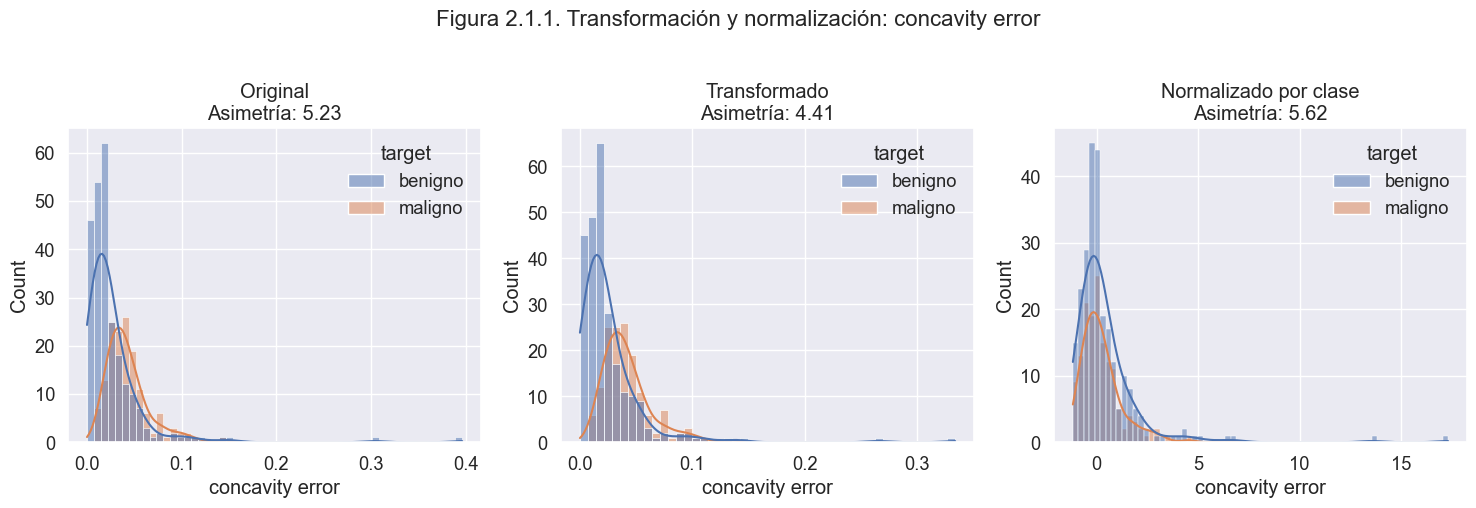

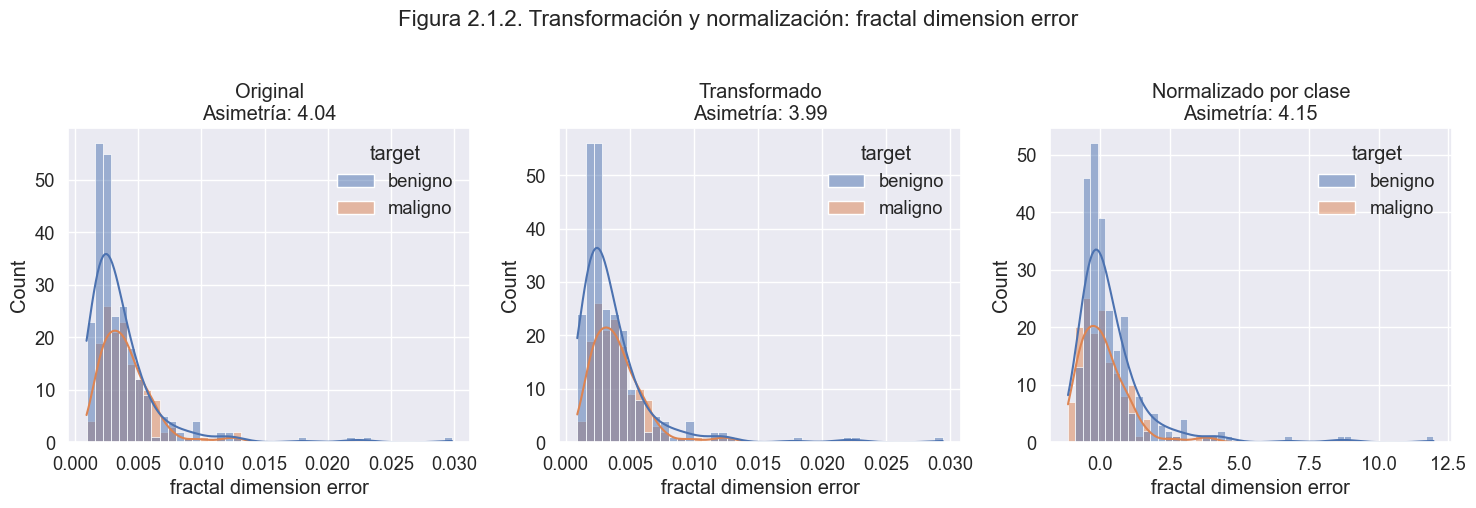

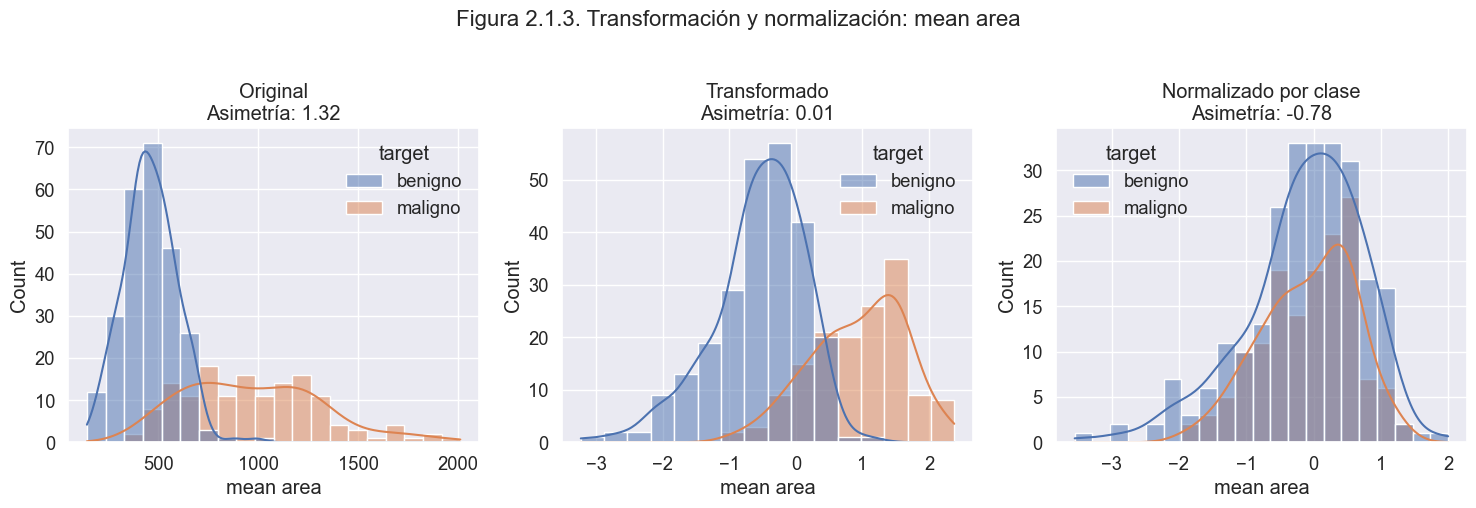

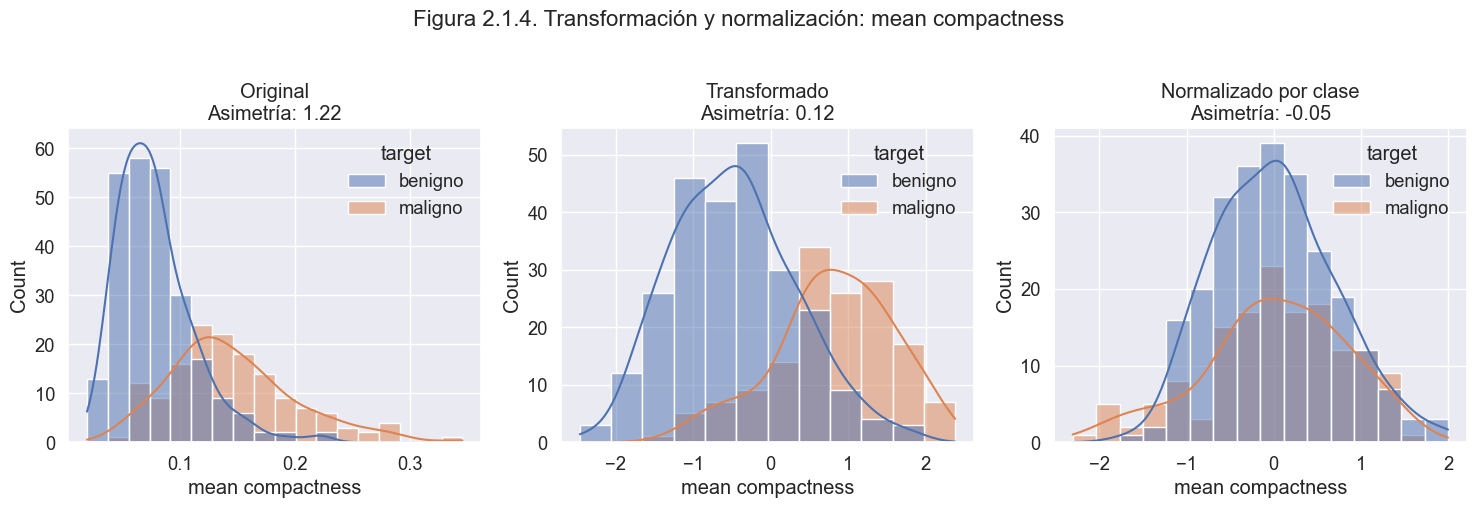

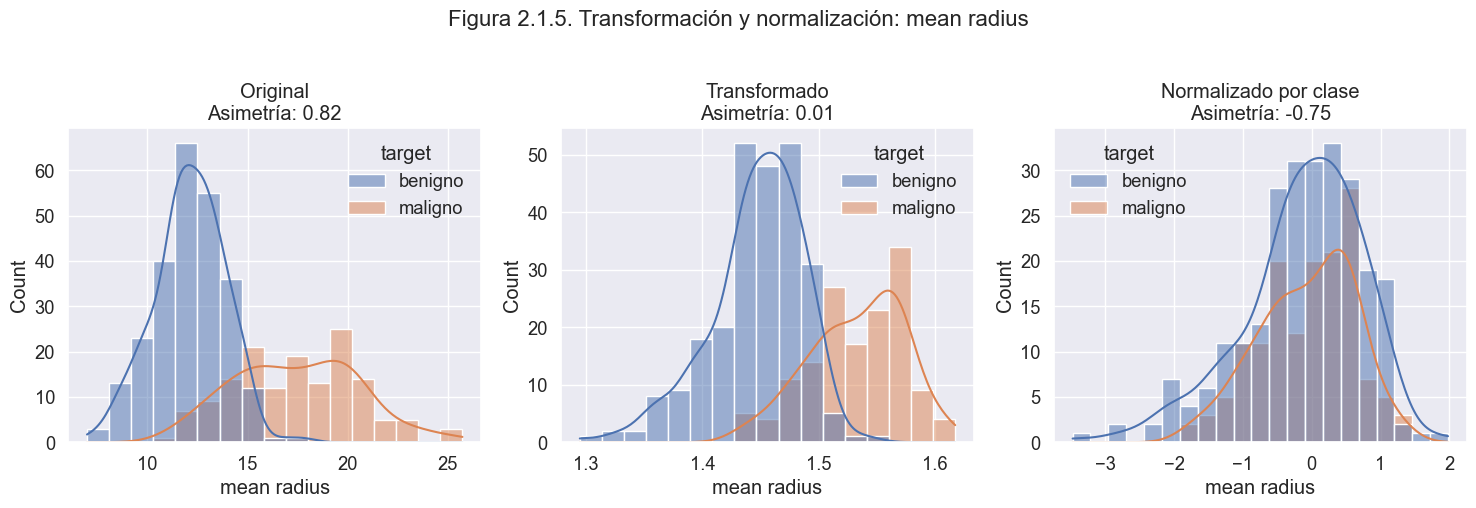

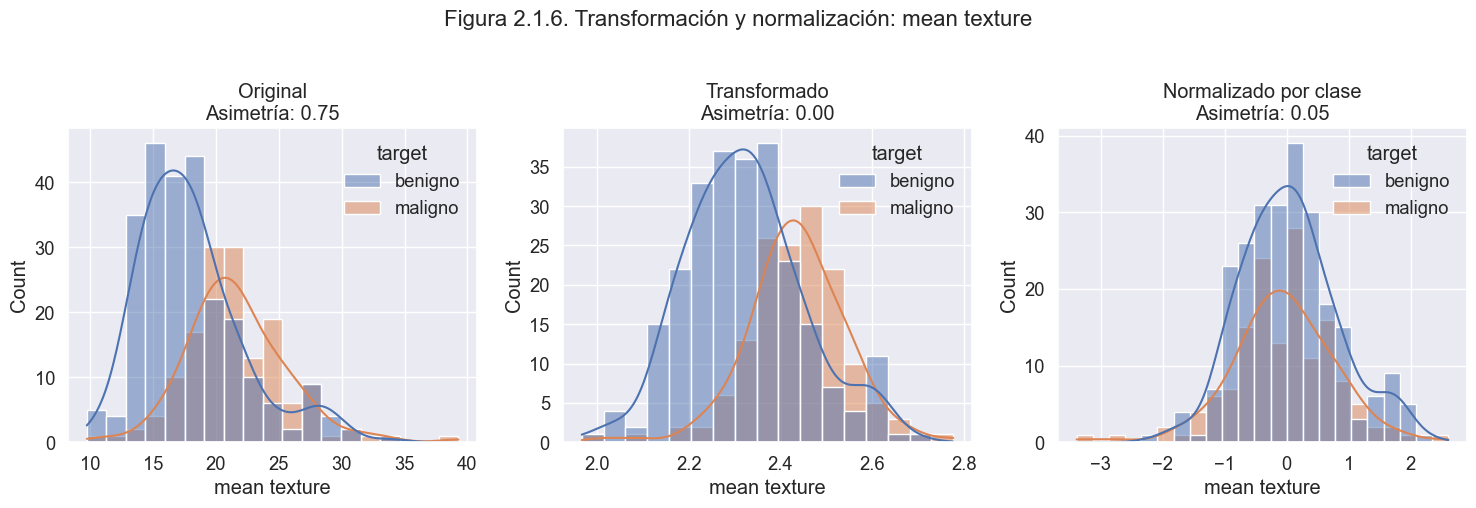

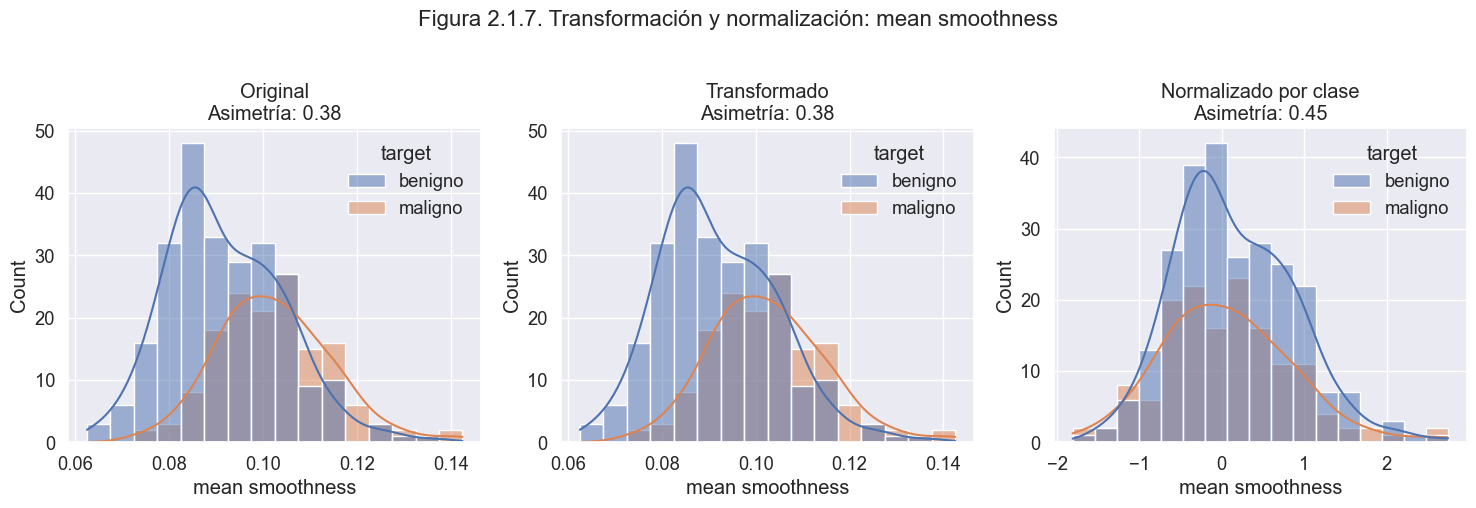

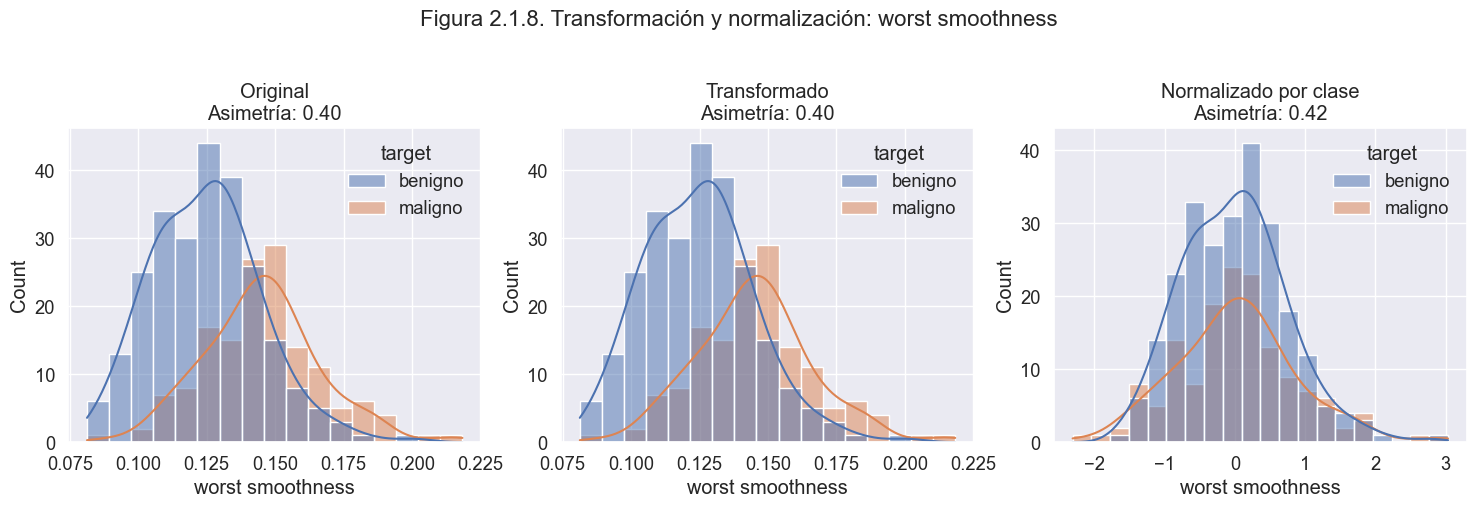

In [18]:
# 6. Visualización para variables representativas
idx = 0
for feature in representative_vars:
    idx = idx + 1
    plt.figure(figsize=(15, 5))
    
    # Original
    plt.subplot(1, 3, 1)
    sns.histplot(data=X_train.join(y_train_labels), x=feature, hue=y_train_labels, kde=True)
    plt.title(f'Original\nAsimetría: {skew_original[feature]:.2f}')
    
    # Transformado
    plt.subplot(1, 3, 2)
    sns.histplot(data=X_train_transformed.join(y_train_labels), x=feature, hue=y_train_labels, kde=True)
    plt.title(f'Transformado\nAsimetría: {skew_transformed[feature]:.2f}')
    
    # Normalizado por clase
    plt.subplot(1, 3, 3)
    sns.histplot(data=X_train_normalized_by_class.join(y_train_labels), x=feature, hue=y_train_labels, kde=True)
    plt.title(f'Normalizado por clase\nAsimetría: {skew_normalized[feature]:.2f}')
    
    plt.suptitle(f'Figura 2.1.{idx}. Transformación y normalización: {feature}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{feature.replace(' ', '_')}_normalization.png", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()

La **Figura 2.2** La evolución de los gráficos Q-Q en la transformación. 

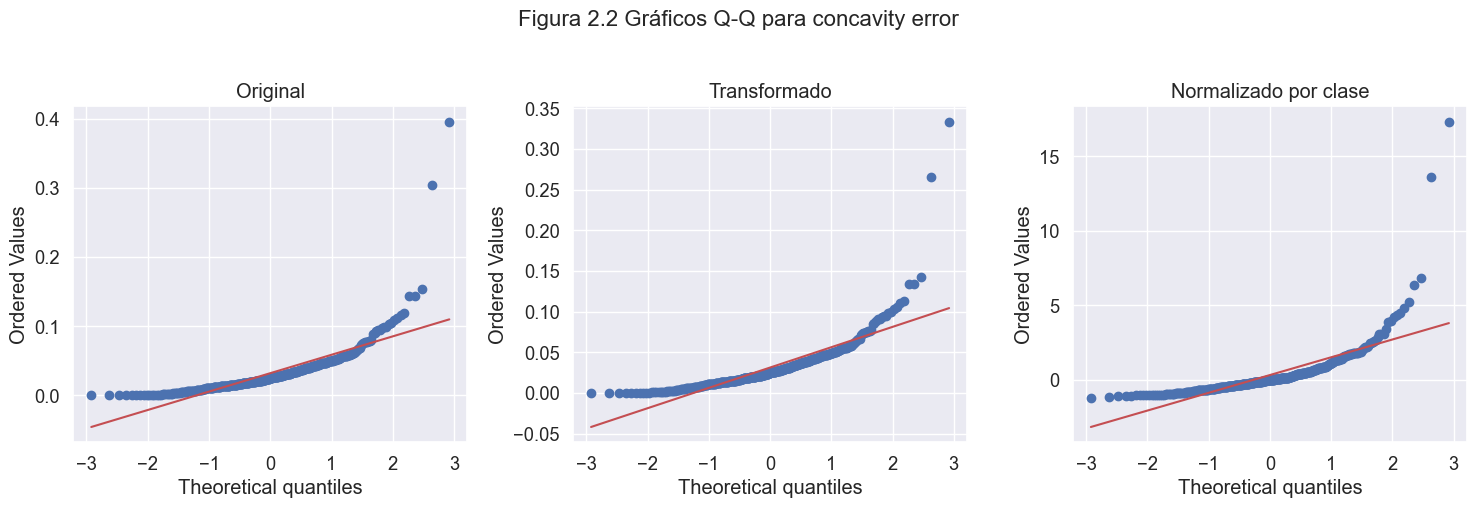

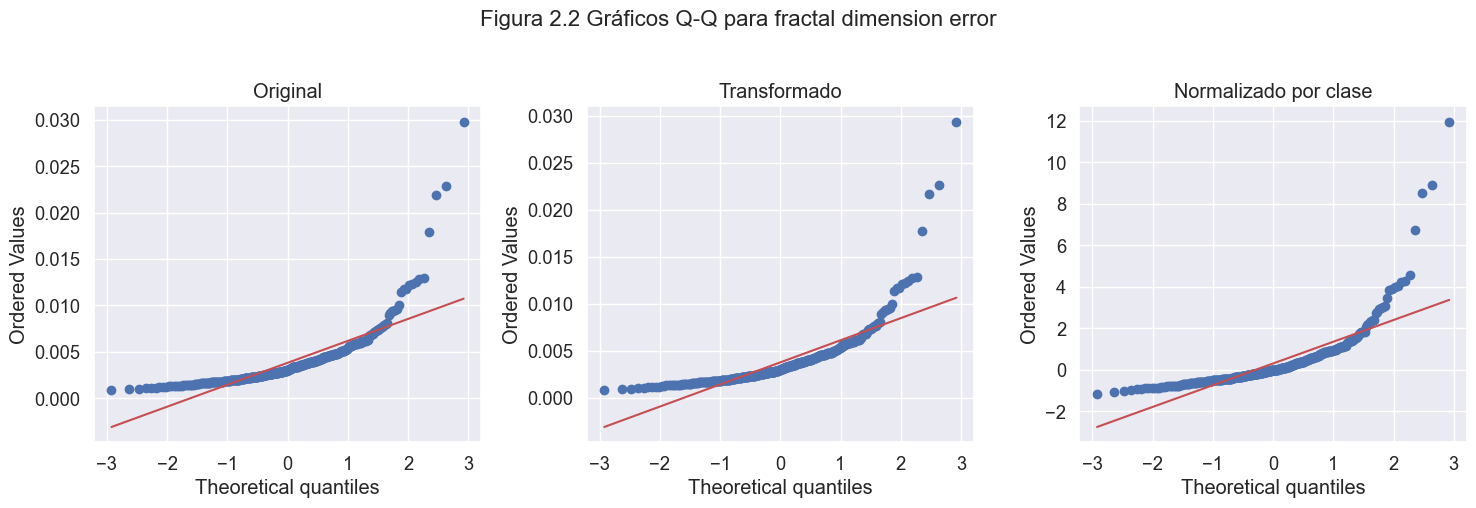

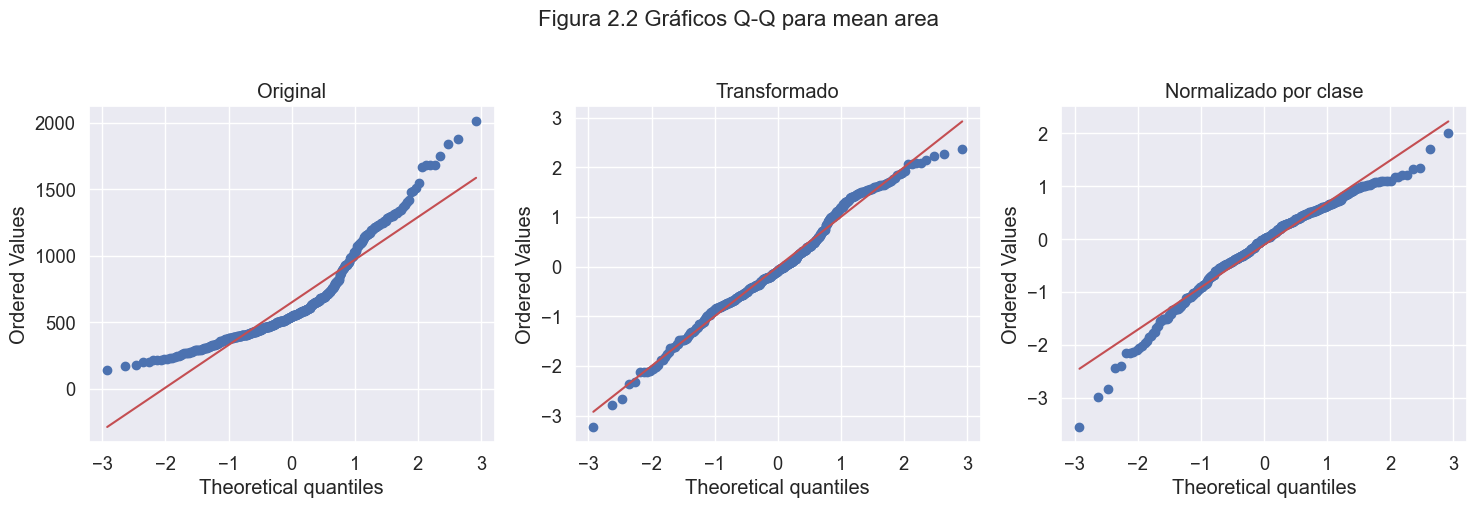

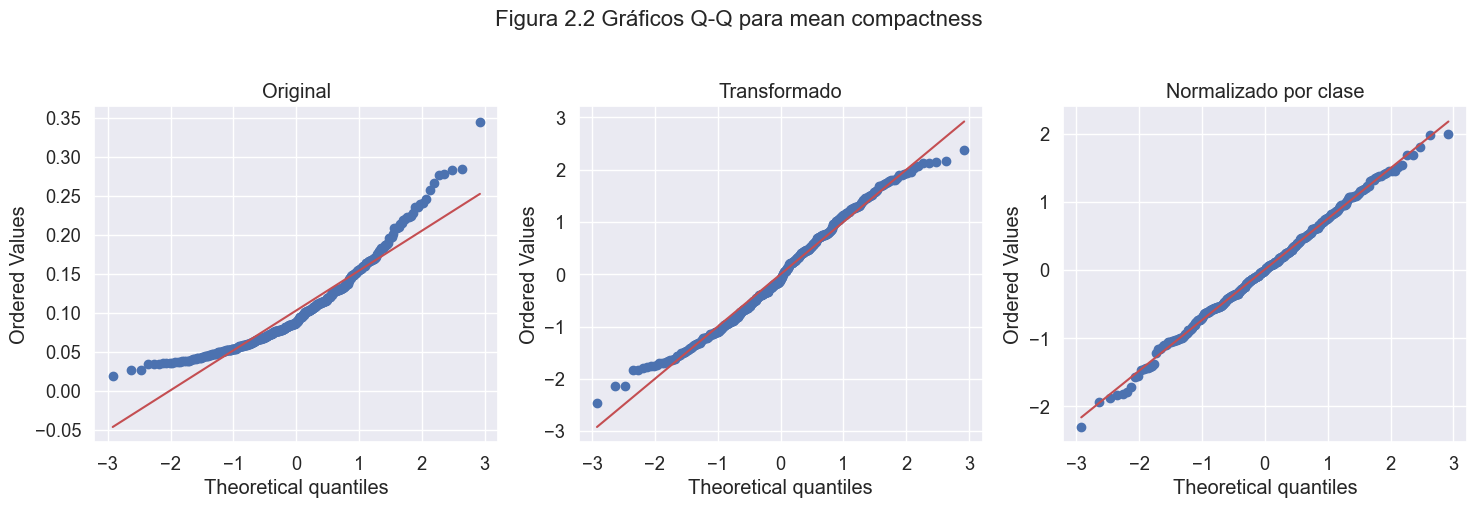

In [11]:
# 7. Gráfico Q-Q para evaluar normalidad en variables representativas
for feature in representative_vars[:4]:  # Limitamos a 4 para no generar demasiados gráficos
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    stats.probplot(X_train[feature], dist="norm", plot=axes[0])
    axes[0].set_title(f'Original')
    
    # Transformado
    stats.probplot(X_train_transformed[feature], dist="norm", plot=axes[1])
    axes[1].set_title(f'Transformado')
    
    # Normalizado
    stats.probplot(X_train_normalized_by_class[feature], dist="norm", plot=axes[2])
    axes[2].set_title(f'Normalizado por clase')
    
    plt.suptitle(f'Figura 2.2 Gráficos Q-Q para {feature}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{feature.replace(' ', '_')}_qq_plots.png", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()

# 8. Guardar los conjuntos de datos preprocesados
preprocessed_data = {
    'X_train_original': X_train,
    'X_test_original': X_test,
    'X_train_transformed': X_train_transformed,
    'X_test_transformed': X_test_transformed,
    'X_train_normalized': X_train_normalized_by_class,
    'X_test_normalized': X_test_normalized_by_class,
    'y_train': y_train,
    'y_test': y_test
}

### <font color="#000000"> 2.1.2. Resultados de la normalización para los valores atípicos</font><a id="section212"></a>

La **Tabla 2.4** muestra el efecto de la normalización en los valores atípicos para todas las variables. Observamos resultados diversos: algunas variables presentan una reducción significativa de outliers (como "area error" con 91.84% y "symmetry error" con 100%), mientras que otras experimentan un aumento (como "worst concave points" y "mean concave points"). Para estas variables, optamos por mantener sus valores originales en el conjunto preprocesado, aplicando únicamente un escalado mínimo para compatibilidad con el resto de variables normalizadas.

In [12]:
# Reevaluación de outliers utilizando la metodología por clase
outliers_original_byclass = detect_outliers_comprehensive(X_train, y_train_labels, method="iqr")
outliers_transformed_byclass = detect_outliers_comprehensive(X_train_transformed, y_train_labels, method="iqr")
outliers_normalized_byclass = detect_outliers_comprehensive(X_train_normalized_by_class, y_train_labels, method="iqr")

# Crear un DataFrame con el desglose por clase para el conjunto normalizado
outliers_byclass_detail = pd.DataFrame({
    'Total Original': outliers_original_byclass['count_total'],
    'Total Normalizado': outliers_normalized_byclass['count_total'],
    'Malignos Original': outliers_original_byclass['count_maligno'],
    'Malignos Normalizado': outliers_normalized_byclass['count_maligno'],
    'Benignos Original': outliers_original_byclass['count_benigno'],
    'Benignos Normalizado': outliers_normalized_byclass['count_benigno']
})

# Calculamos las reducciones porcentuales
outliers_byclass_detail['Reducción Total (%)'] = (1 - outliers_byclass_detail['Total Normalizado'] / 
                                                outliers_byclass_detail['Total Original']) * 100

# Para evitar divisiones por cero
outliers_byclass_detail['Reducción Malignos (%)'] = outliers_byclass_detail.apply(
    lambda row: (1 - row['Malignos Normalizado'] / row['Malignos Original']) * 100 
    if row['Malignos Original'] > 0 else 0, axis=1)

outliers_byclass_detail['Reducción Benignos (%)'] = outliers_byclass_detail.apply(
    lambda row: (1 - row['Benignos Normalizado'] / row['Benignos Original']) * 100 
    if row['Benignos Original'] > 0 else 0, axis=1)

# Ordenamos por la cantidad original de outliers (descendente)
outliers_sorted_byclass_detail = outliers_byclass_detail.sort_values('Reducción Total (%)', ascending=False)

print("Tabla 2.4. Efecto de la normalización en los valores atípicos desglosados por clase:")
display(outliers_sorted_byclass_detail.round(2))

Tabla 2.4. Efecto de la normalización en los valores atípicos desglosados por clase:


,Total Original,Total Normalizado,Malignos Original,Malignos Normalizado,Benignos Original,Benignos Normalizado,Reducción Total (%),Reducción Malignos (%),Reducción Benignos (%)
symmetry error,20,0,12,0,8,0,100.00,100.00,100.00
mean fractal dimension,12,0,1,0,11,0,100.00,100.00,100.00
perimeter error,27,1,8,0,12,1,96.30,100.00,91.67
worst fractal dimension,19,1,3,0,8,1,94.74,100.00,87.50
texture error,15,1,3,1,10,0,93.33,66.67,100.00
radius error,29,2,1,0,9,2,93.10,100.00,77.78
mean compactness,12,1,6,1,7,2,91.67,83.33,71.43
smoothness error,22,2,5,2,13,0,90.91,60.00,100.00
worst compactness,14,2,8,2,6,0,85.71,75.00,100.00
area error,40,6,3,0,13,6,85.00,100.00,53.85


Obtenemos las variables cuya reducción es negativa. Es decir, aquellas para las que las transformaciones no funcionaron adecuadamente. y aplicamos un escalado simple a las varibles conflictivas

In [13]:
# Identificar variables problemáticas basadas en reducción negativa (aumento de outliers)
problematic_vars = outliers_byclass_detail[outliers_byclass_detail['Reducción Total (%)'] < 0].index.tolist()

print(f"Variables problemáticas identificadas automáticamente ({len(problematic_vars)}):")
for var in problematic_vars:
    print(f"- {var} (reducción: {outliers_byclass_detail.loc[var, 'Reducción Total (%)']:.2f}%)")

# Crear una copia del conjunto normalizado para modificar
X_train_final = X_train_normalized_by_class.copy()
X_test_final = X_test_normalized_by_class.copy()

# Restaurar los valores originales para las variables problemáticas y aplicar solo un escalado mínimo
for feature in problematic_vars:
    # Calculamos los rangos para cada variable usando solo el conjunto de entrenamiento
    data_min = X_train[feature].min()
    data_max = X_train[feature].max()
    data_range = data_max - data_min
    
    # Aplicamos un escalado simple al rango [-1, 1] para compatibilidad con las otras variables normalizadas
    X_train_final[feature] = (X_train[feature] - data_min) / data_range * 2 - 1
    X_test_final[feature] = (X_test[feature] - data_min) / data_range * 2 - 1

Variables problemáticas identificadas automáticamente (8):
- mean radius (reducción: -10.00%)
- mean smoothness (reducción: -33.33%)
- mean concave points (reducción: -100.00%)
- concavity error (reducción: -36.84%)
- concave points error (reducción: -17.65%)
- fractal dimension error (reducción: -26.32%)
- worst smoothness (reducción: -100.00%)
- worst concave points (reducción: -inf%)


Guardamos el dataset preprocesado

In [14]:
# Guardar los conjuntos finales de datos preprocesados
preprocessed_data = {
    'X_train_original': X_train,
    'X_test_original': X_test,
    'X_train_transformed': X_train_transformed,
    'X_test_transformed': X_test_transformed,
    'X_train_normalized': X_train_normalized_by_class,
    'X_test_normalized': X_test_normalized_by_class,
    'X_train_final': X_train_final,  # Versión con tratamiento especial para variables problemáticas
    'X_test_final': X_test_final,    # Versión con tratamiento especial para variables problemáticas
    'y_train': y_train,
    'y_test': y_test
}

# También podemos guardar la información sobre qué variables recibieron tratamiento especial
preprocessed_metadata = {
    'problematic_variables': problematic_vars,
    'transformation_groups': {
        'extreme_skew': extreme_skew,
        'high_skew': high_skew,
        'moderate_skew': moderate_skew,
        'low_skew': low_skew
    },
    'preprocessing_strategy': {
        'extreme_skew': 'logarithmic transformation',
        'high_skew': 'Yeo-Johnson transformation',
        'moderate_skew': 'Yeo-Johnson transformation (gentle)',
        'low_skew': 'RobustScaler only',
        'problematic_vars': 'MinMax scaling to [-1,1] range'
    }
}

In [15]:
# Creamos directorio para los datos preprocesados si no existe
os.makedirs('data/preprocessed', exist_ok=True)

# Guardamos los datos preprocesados
with open('data/preprocessed/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

# Guardamos los metadatos del preprocesamiento
with open('data/preprocessed/preprocessed_metadata.pkl', 'wb') as f:
    pickle.dump(preprocessed_metadata, f)

print("Datos preprocesados guardados correctamente.")

Datos preprocesados guardados correctamente.


La **Tabla 2.5** muestra cómo nuestro tratamiento especial afecta a las variables que presentaban un aumento de outliers con la normalización estándar. Al aplicar un simple escalado al rango [-1, 1] para estas variables, preservamos mejor su estructura original mientras aseguramos la compatibilidad de escala con el resto de variables normalizadas.

Los resultados confirman que este enfoque híbrido consigue mantener el número de outliers similar al de los datos originales para estas variables problemáticas, evitando las distorsiones que producía la normalización completa. Esto es particularmente importante para variables relacionadas con concavidad y textura, que probablemente capturan patrones morfológicos distintivos entre tumores benignos y malignos.

Este preprocesamiento adaptativo nos permitirá avanzar a la fase de selección de características con un conjunto de datos que mantiene la información discriminativa original mientras está adecuadamente preparado para el modelado con algoritmos de aprendizaje automático.

In [16]:
# Verificar outliers en el conjunto final con tratamiento especial
outliers_final_byclass = detect_outliers_comprehensive(X_train_final, y_train_labels, method="iqr")

# Crear un DataFrame comparativo para las variables problemáticas
outliers_comparison_final = pd.DataFrame({
    'Original': outliers_original_byclass['count_total'],
    'Normalizado': outliers_normalized_byclass['count_total'],
    'Final (tratamiento especial)': outliers_final_byclass['count_total']
})

# Calcular reducciones porcentuales
outliers_comparison_final['Reducción Norm. (%)'] = (1 - outliers_comparison_final['Normalizado'] / 
                                                 outliers_comparison_final['Original']) * 100

outliers_comparison_final['Reducción Final (%)'] = (1 - outliers_comparison_final['Final (tratamiento especial)'] / 
                                                  outliers_comparison_final['Original']) * 100

# Mostrar solo las variables problemáticas
print("Tabla 2.5. Detalle de variables con tratamiento especial:")
display(outliers_comparison_final.loc[problematic_vars].sort_values('Original', ascending=False).round(2))

# Estadísticas globales
total_original = outliers_original_byclass['count_total'].sum()
total_normalized = outliers_normalized_byclass['count_total'].sum()
total_final = outliers_final_byclass['count_total'].sum()

Tabla 2.5. Detalle de variables con tratamiento especial:


,Original,Normalizado,Final (tratamiento especial),Reducción Norm. (%),Reducción Final (%)
concavity error,19,26,19,-36.84,0.0
fractal dimension error,19,24,19,-26.32,0.0
concave points error,17,20,17,-17.65,0.0
mean radius,10,11,10,-10.00,0.0
mean concave points,6,12,6,-100.00,0.0
mean smoothness,3,4,3,-33.33,0.0
worst smoothness,3,6,3,-100.00,0.0
worst concave points,0,4,0,-inf,NaN
